In [1]:
img_width = 224
img_height = 224
symbol = "vgg"

In [2]:
import numpy as np
from keras.applications import vgg16, resnet50
from keras import backend as K
K.set_learning_phase(0)  # Test
import imageio
from IPython.display import Image

Using TensorFlow backend.


In [3]:
if symbol == "resnet":
    model = resnet50.ResNet50(include_top=True, weights='imagenet')
    print(model.summary())
elif symbol == "vgg":
    model = vgg16.VGG16(include_top=False, weights='imagenet')
    print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [4]:
def deprocess_image(x):
    # mean and std list for channels (Imagenet)
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    for c in range(3):
        x[c] /= reverse_std[c]
        x[c] -= reverse_mean[c]
    # Clip between 0 and 1
    x = np.clip(x, 0, 1)
    # Convert to RGB
    x *= 255
    # Shape adj. for diff backend
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    # Convert RGB to GBR   
    #x = x[..., ::-1]
    return x

In [5]:
def preprocess_image(x):
    return x

In [6]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [7]:
def get_visuals_for(layer_name, layer_dict, num_to_extract=None):
    
    kept_filters = []
    layer_output = layer_dict[layer_name].output
    num_filters = int(layer_output.shape[-1])
    print("There are {} filter maps in this layer".format(num_filters))

    # Go through filters
    for filter_index in range(num_filters):
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])
        # Compute gradient
        grads = K.gradients(loss, input_img)[0]
        # Normalise grad
        grads = normalize(grads)
        # Return loss
        iterate = K.function([input_img], [loss, grads])
        # Lr for gradient ascent
        lr = 1.
        # Start with gray image with noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 3, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 3))
        # Process input
        input_img_data = preprocess_image(input_img_data)
        # Run gradient ascent
        # Maybe try stochastic??
        for i in range(50):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * lr
            if loss_value <= 0.:
                break
        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
            #print('Filter %d processed' % (filter_index))
            if len(kept_filters) >= num_to_extract:
                return kept_filters
            
    # Extracted less than desired
    return kept_filters

In [8]:
def best_filters(visual_filts, num):
    visual_filts.sort(key=lambda x: x[1], reverse=True)
    return visual_filts[:num]

In [9]:
def plot_filters_square(filts, n, name):
    margin = 1
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))
    # Dill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = filts[i * n + j]
            stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                             (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img
    # Save        
    stitched_filters = stitched_filters.astype('uint8')
    imageio.imwrite('%s_%dx%d.png' % (name, n, n), stitched_filters)
    # Visualise
    return Image('%s_%dx%d.png' % (name, n, n))

In [10]:
def visualise_convo_filters(layer_name, plot_n=3):
    how_many_more_to_collect_before_chopping = 10  # 1, 2, or None    
    # Get visualised filter maps (more than amount to plot so that can sort by loss and keep best)
    # In theory the more redundancy the better the images
    visual_filts = get_visuals_for(layer_name=layer_name, 
                                   layer_dict=layer_dict,
                                   num_to_extract=how_many_more_to_collect_before_chopping*plot_n*plot_n)
    # Trim to just best filters
    visual_filts_trim = best_filters(visual_filts, num=plot_n*plot_n)
    # Save and plot square
    return plot_filters_square(filts=visual_filts_trim, n=plot_n, name=symbol+"_"+layer_name)

In [11]:
# Possible CNN filters to choose from
input_img = model.input # input place-holder
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
cnn_filters = [k for k, v in layer_dict.items() if "convolutional" in str(v)]
print(cnn_filters)

['block5_conv2', 'block3_conv3', 'block2_conv2', 'block3_conv2', 'block1_conv2', 'block3_conv1', 'block5_conv3', 'block4_conv1', 'block5_conv1', 'block1_conv1', 'block4_conv2', 'block4_conv3', 'block2_conv1']


### Visualise different layers

There are 64 filter maps in this layer
CPU times: user 24.9 s, sys: 8.04 s, total: 32.9 s
Wall time: 43.6 s


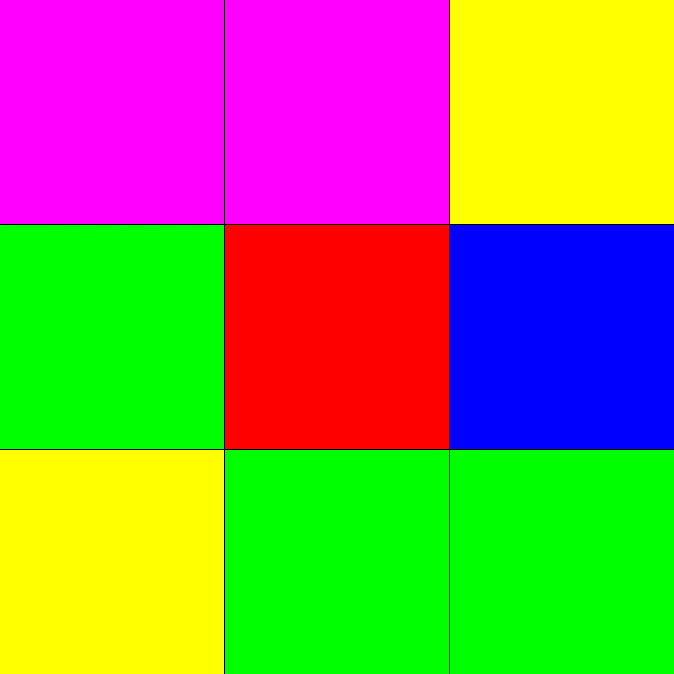

In [12]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block1_conv2')

# This one came out wrong ... I think it 
# needs to have GD run for fewer iterations
# A bit like L1 norm -> either something or nothing comes out


There are 128 filter maps in this layer
CPU times: user 1min 17s, sys: 18.3 s, total: 1min 35s
Wall time: 2min 41s


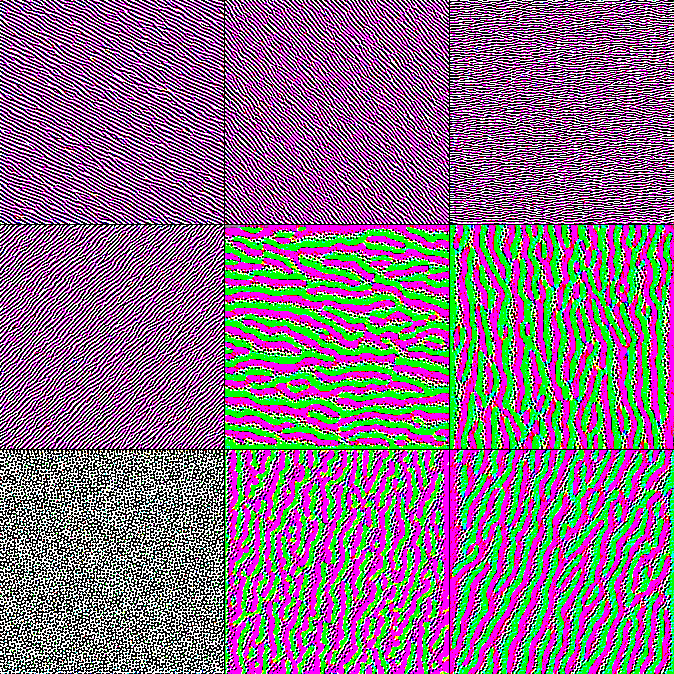

In [13]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block2_conv2')

There are 256 filter maps in this layer
CPU times: user 2min 11s, sys: 26.8 s, total: 2min 37s
Wall time: 5min 45s


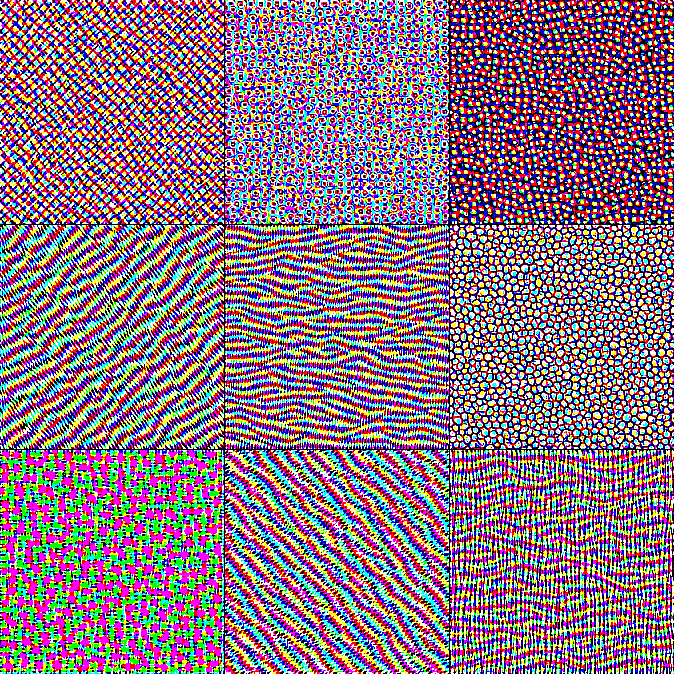

In [14]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block3_conv2')

There are 512 filter maps in this layer
CPU times: user 3min 40s, sys: 40.7 s, total: 4min 21s
Wall time: 8min 52s


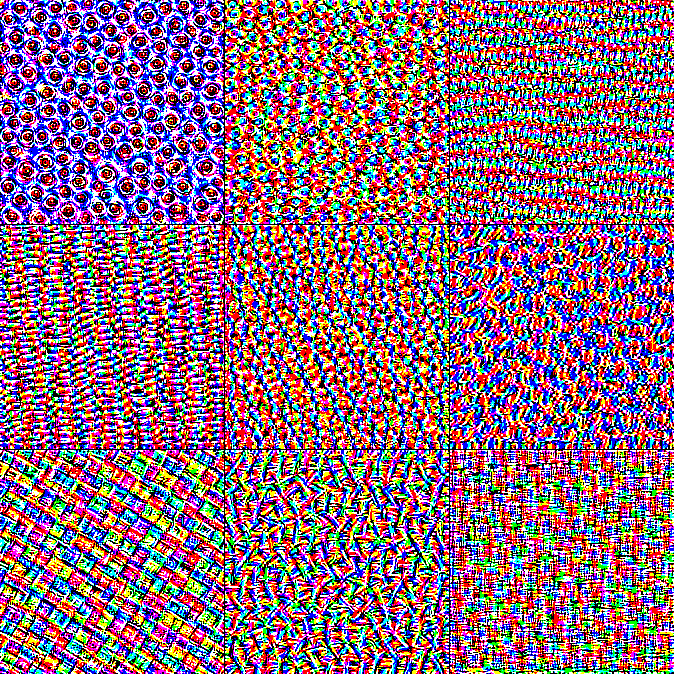

In [15]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block4_conv2')

There are 512 filter maps in this layer
CPU times: user 4min 27s, sys: 42.8 s, total: 5min 10s
Wall time: 9min 30s


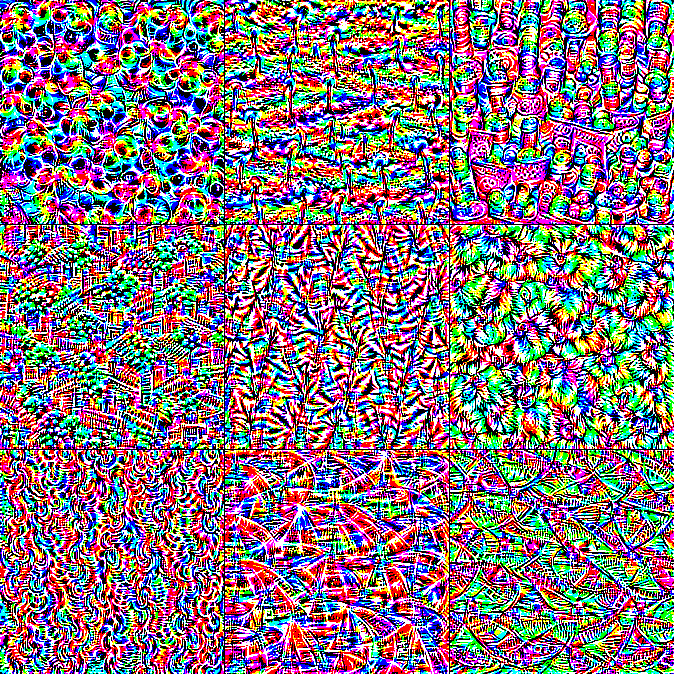

In [16]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block5_conv1')

There are 512 filter maps in this layer
CPU times: user 10min, sys: 57.9 s, total: 10min 58s
Wall time: 15min 14s


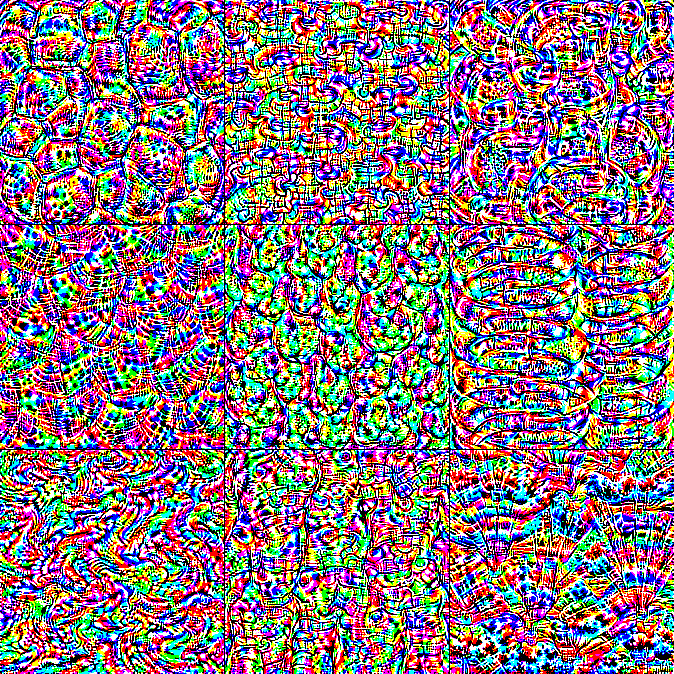

In [17]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block5_conv3')

There are 512 filter maps in this layer
CPU times: user 7min 23s, sys: 44.5 s, total: 8min 8s
Wall time: 9min 34s


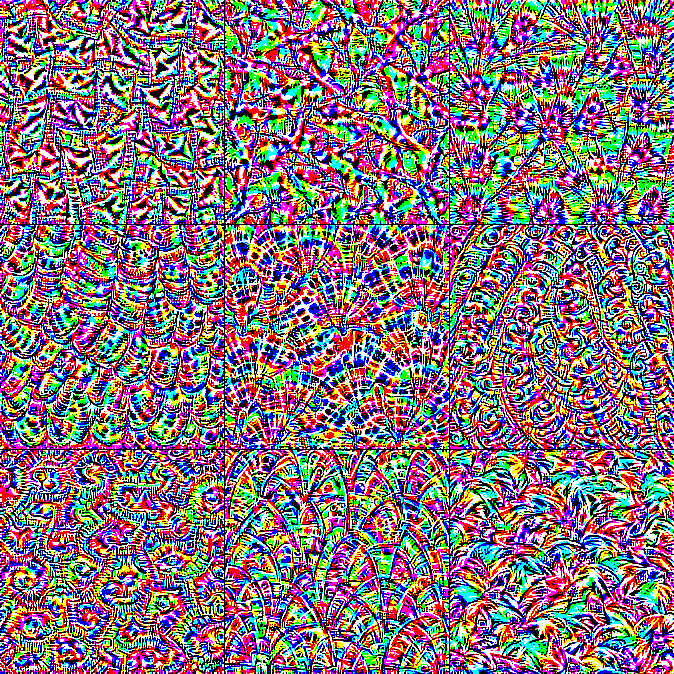

In [18]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block5_conv2')

There are 512 filter maps in this layer
CPU times: user 6min 1s, sys: 30.4 s, total: 6min 31s
Wall time: 7min 26s


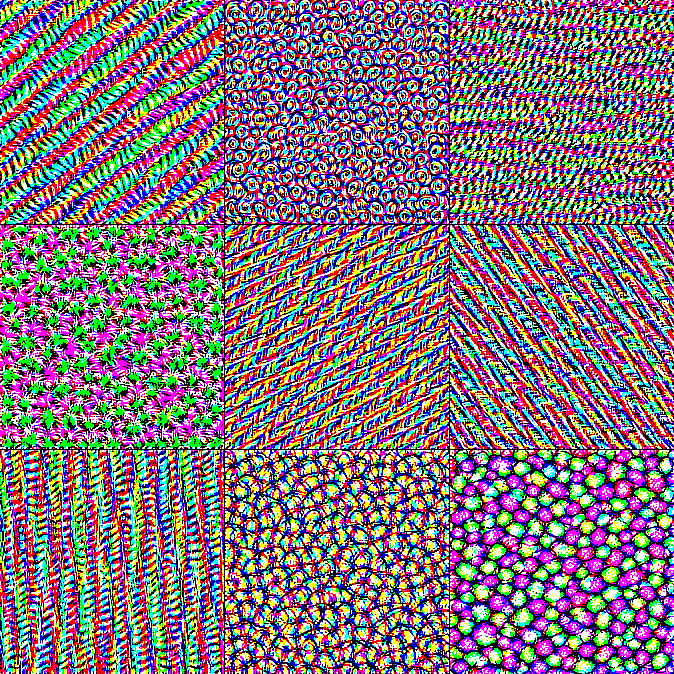

In [19]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block4_conv1')

There are 512 filter maps in this layer
CPU times: user 8min 53s, sys: 38.8 s, total: 9min 31s
Wall time: 10min 47s


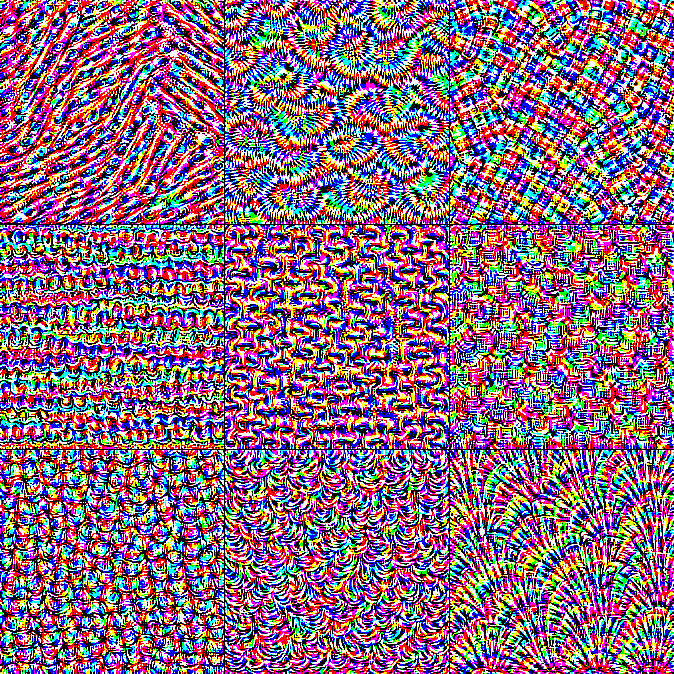

In [20]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block4_conv3')

There are 256 filter maps in this layer
CPU times: user 6min 3s, sys: 21.5 s, total: 6min 24s
Wall time: 6min 54s


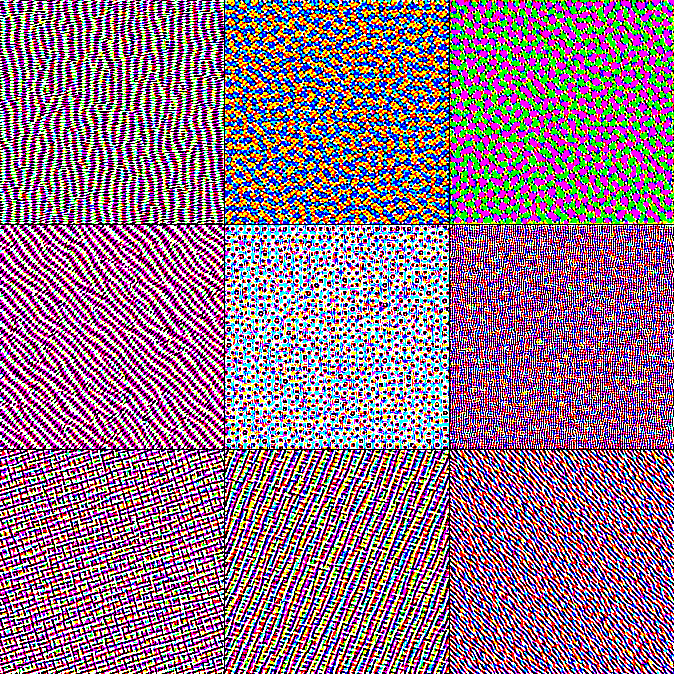

In [21]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block3_conv1')

There are 256 filter maps in this layer
CPU times: user 6min 53s, sys: 26.9 s, total: 7min 20s
Wall time: 8min 7s


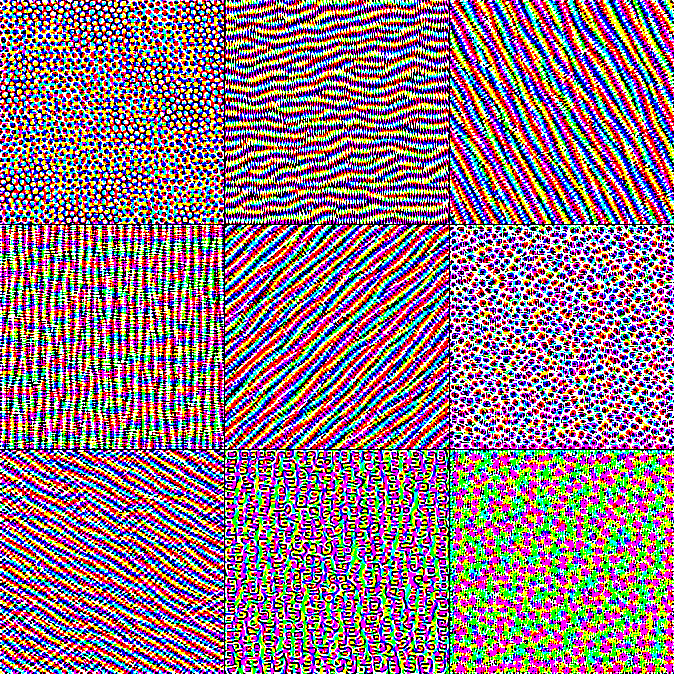

In [22]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block3_conv3')

There are 128 filter maps in this layer
CPU times: user 6min 23s, sys: 18.1 s, total: 6min 41s
Wall time: 6min 57s


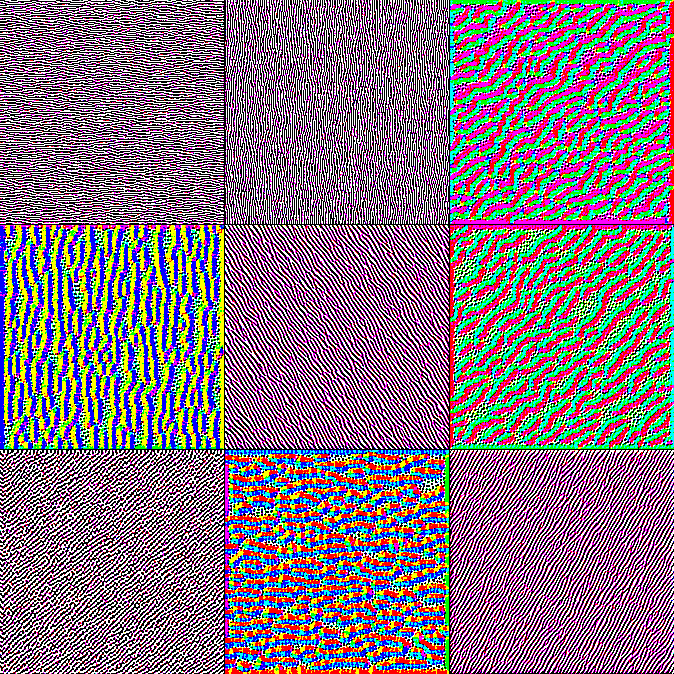

In [23]:
%%time
# Visualise filters from this layer
visualise_convo_filters('block2_conv1')